In [ ]:
import os
from google.colab import userdata

# Kaggle kimlik bilgilerini ortam değişkenlerine ayarla
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

print("Kaggle kimlik bilgileri başarıyla ayarlandı.")

Kaggle kimlik bilgileri başarıyla ayarlandı.


In [ ]:
# Veri setini indir
!kaggle datasets download -d ipythonx/mvtec-ad

# İndirilen zip dosyasını aç
!unzip mvtec-ad.zip -d /content/mvtec-ad

print("Veri seti başarıyla indirildi ve açıldı.")

Dataset URL: https://www.kaggle.com/datasets/ipythonx/mvtec-ad
License(s): copyright-authors
User cancelled operation
Archive:  mvtec-ad.zip
replace /content/mvtec-ad/bottle/ground_truth/broken_large/000_mask.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Veri seti başarıyla indirildi ve açıldı.


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt

def ssim_loss(y_true, y_pred):
    return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)

In [ ]:
def load_images(data_path, img_size=(256, 256)):
    images = []
    for img_file in Path(data_path).glob('**/*.png'):
        img = cv2.imread(str(img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0
        images.append(img)
    return np.array(images)

#Büyük işlemlerde DataLoader kullanmak ram için daha verimli
category = 'leather'  # kategori
train_path = f'/content/mvtec-ad/{category}/train/good'

train_images = load_images(train_path)

In [ ]:
def build_autoencoder(input_shape=(256, 256, 3)):
    # Encoder
    encoder_input = keras.Input(shape=input_shape)

    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = keras.layers.UpSampling2D((2, 2))(x)

    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.UpSampling2D((2, 2))(x)

    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.UpSampling2D((2, 2))(x)

    decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(encoder_input, decoded)
    return autoencoder

model = build_autoencoder()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model derleme
model.compile(
    optimizer='adam',
    loss=ssim_loss,  # SSIM loss kullanıldı
    metrics=['mae']
)

# Eğitim
history = model.fit(
    train_images, train_images,  # Input ve output aynı
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    shuffle=True,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
)

# Modeli kaydetme
model.save('autoencoder_model.h5')

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 907ms/step - loss: 0.5384 - mae: 0.1647 - val_loss: 0.4802 - val_mae: 0.0734 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.4794 - mae: 0.0644 - val_loss: 0.4687 - val_mae: 0.0499 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.4713 - mae: 0.0482 - val_loss: 0.4659 - val_mae: 0.0435 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.4688 - mae: 0.0446 - val_loss: 0.4646 - val_mae: 0.0433 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.4646 - mae: 0.0442 - val_loss: 0.4636 - val_mae: 0.0400 - learning_rate: 0.0010
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.4647 - mae: 0.0417 - val_loss: 0.4622 - val_mae: 0.0386 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.4623 - mae: 0.0406 - val_loss: 0.4619 - val_mae: 0.0384 - learning_rate: 0.0010
Epoch 8/100


In [ ]:
def detect_anomalies(model, test_images, threshold=None):
    # Rekonstrüksiyon
    reconstructed = model.predict(test_images)

    # Rekonstrüksiyon hatası
    mse = np.mean(np.square(test_images - reconstructed), axis=(1, 2, 3))

    # Threshold belirleme (eğer verilmemişse)
    if threshold is None:
        threshold = np.mean(mse) + 2 * np.std(mse)

    # Anomali tespiti
    anomalies = mse > threshold

    return mse, anomalies, reconstructed

# Test veri yükleme
test_path = f'/content/mvtec-ad/{category}/test'
test_images = load_images(test_path)

# Anomali tespiti
mse_scores, is_anomaly, reconstructed = detect_anomalies(model, test_images)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step


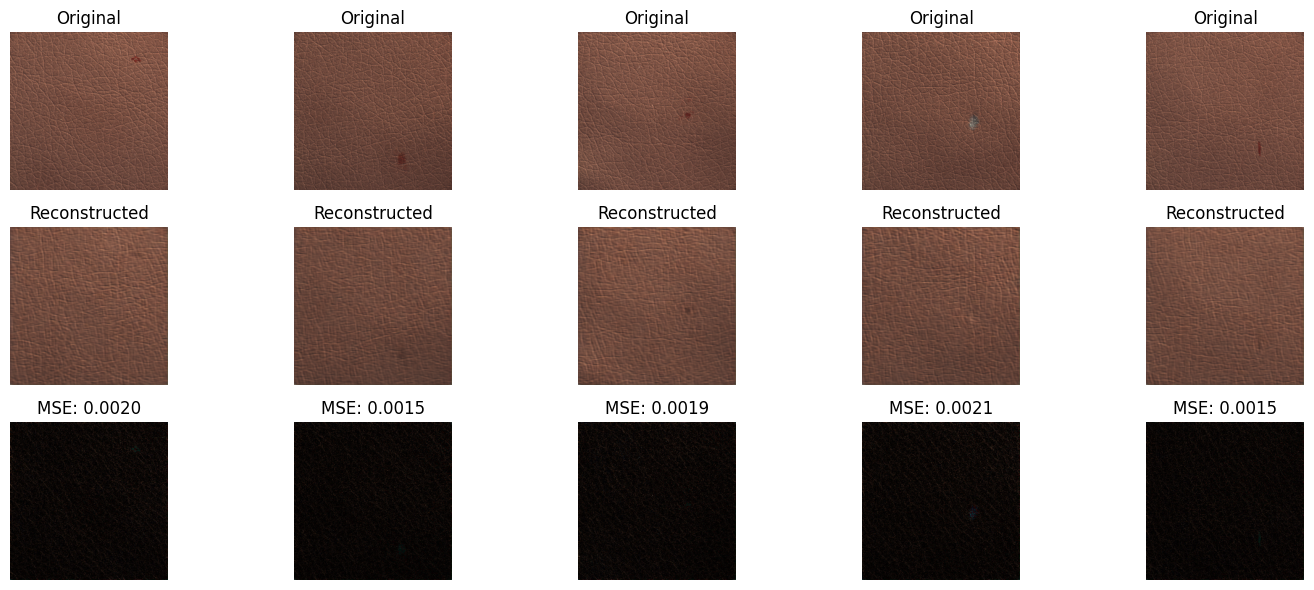

In [ ]:
def visualize_results(original, reconstructed, mse, n_samples=5):
    plt.figure(figsize=(15, 6))

    for i in range(n_samples):
        # Orijinal görüntü
        plt.subplot(3, n_samples, i + 1)
        plt.imshow(original[i])
        plt.title(f'Original')
        plt.axis('off')

        # Rekonstrüksiyon
        plt.subplot(3, n_samples, n_samples + i + 1)
        plt.imshow(reconstructed[i])
        plt.title(f'Reconstructed')
        plt.axis('off')

        # Fark haritası
        plt.subplot(3, n_samples, 2*n_samples + i + 1)
        diff = np.abs(original[i] - reconstructed[i])
        plt.imshow(diff)
        plt.title(f'MSE: {mse[i]:.4f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_results(test_images, reconstructed, mse_scores)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


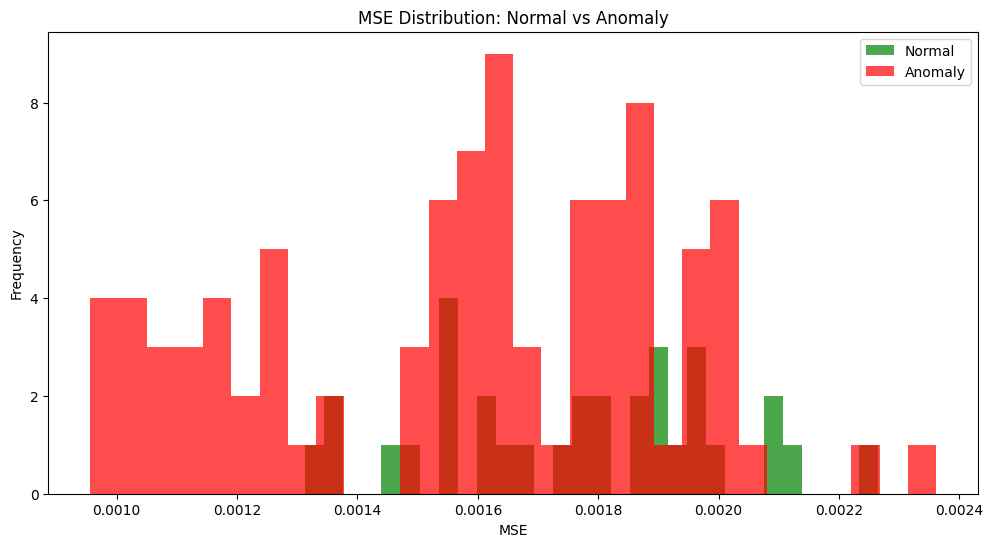

Normal MSE: 0.001763 ± 0.000239
Anomaly MSE: 0.001578 ± 0.000336
Separation ratio: 0.89x


In [ ]:
def evaluate_model(model, category=category):
    # Normal örnekler
    normal_path = f'/content/mvtec-ad/{category}/test/good'
    normal_images = load_images(normal_path)
    normal_recon = model.predict(normal_images)
    normal_mse = np.mean(np.square(normal_images - normal_recon), axis=(1,2,3))

    # Anomalili örnekler (tüm defekt tipleri)
    anomaly_mse = []
    defect_types = []

    test_path = Path(f'/content/mvtec-ad/{category}/test')
    for defect_dir in test_path.iterdir():
        if defect_dir.name != 'good' and defect_dir.is_dir():
            anomaly_images = load_images(str(defect_dir))
            anomaly_recon = model.predict(anomaly_images)
            mse = np.mean(np.square(anomaly_images - anomaly_recon), axis=(1,2,3))
            anomaly_mse.extend(mse)
            defect_types.extend([defect_dir.name] * len(mse))

    anomaly_mse = np.array(anomaly_mse)

    # Görselleştirme
    plt.figure(figsize=(12, 6))
    plt.hist(normal_mse, bins=30, alpha=0.7, label='Normal', color='green')
    plt.hist(anomaly_mse, bins=30, alpha=0.7, label='Anomaly', color='red')
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('MSE Distribution: Normal vs Anomaly')
    plt.show()

    # İstatistikler
    print(f"Normal MSE: {normal_mse.mean():.6f} ± {normal_mse.std():.6f}")
    print(f"Anomaly MSE: {anomaly_mse.mean():.6f} ± {anomaly_mse.std():.6f}")
    print(f"Separation ratio: {anomaly_mse.mean() / normal_mse.mean():.2f}x")

    return normal_mse, anomaly_mse

normal_scores, anomaly_scores = evaluate_model(model)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt

def ssim_loss(y_true, y_pred):
    return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)

Eğitim için 245 görüntü yüklendi.


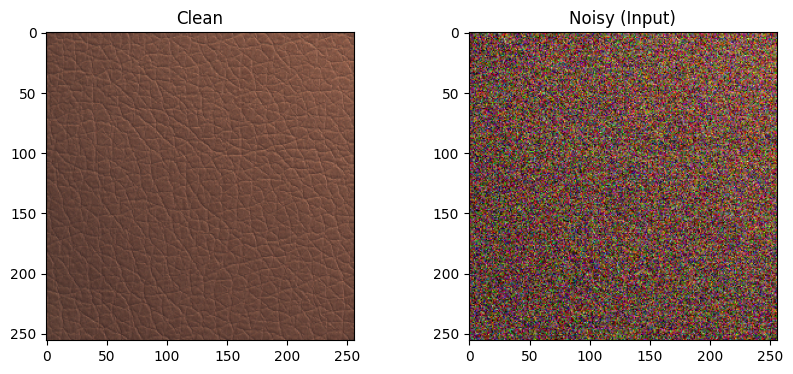

In [ ]:
def load_images(data_path, img_size=(256, 256)):
    images = []
    path_obj = Path(data_path)
    if not path_obj.exists():
        print(f"Uyarı: {data_path} yolu bulunamadı!")
        return np.array([])

    for img_file in path_obj.glob('**/*.png'):
        img = cv2.imread(str(img_file))
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0
        images.append(img)
    return np.array(images)

# NOISE INJECTION FUNCTION
def add_noise(images, noise_factor=0.1):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

category = 'leather'  # kategori
base_path = '/content/mvtec-ad' if os.path.exists('/content/mvtec-ad') else '.'
train_path = f'{base_path}/{category}/train/good'

train_images_clean = load_images(train_path)
# Add noise to create training inputs
train_images_noisy = add_noise(train_images_clean, noise_factor=0.2)

print(f"Eğitim için {len(train_images_clean)} görüntü yüklendi.")

# Show example of noise
if len(train_images_clean) > 0:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1); plt.imshow(train_images_clean[0]); plt.title('Clean')
    plt.subplot(1, 2, 2); plt.imshow(train_images_noisy[0]); plt.title('Noisy (Input)')
    plt.show()

In [ ]:
def build_autoencoder_simple(input_shape=(256, 256, 3)):
    # Standard Autoencoder (Simpler than before to prevent Identity Mapping)
    encoder_input = keras.Input(shape=input_shape)

    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = keras.layers.MaxPooling2D((2, 2), padding='same')(x) # 128

    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D((2, 2), padding='same')(x) # 64

    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x) # 32x32 BOttleneck
    # Note: We kept it slightly larger (32x32) because Denoising is the main regularizer now.
    # If it still copies, we will reduce to 16x16.

    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = keras.layers.UpSampling2D((2, 2))(x)

    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.UpSampling2D((2, 2))(x)

    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.UpSampling2D((2, 2))(x)

    decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(encoder_input, decoded)
    return autoencoder

model = build_autoencoder_simple()
model.compile(optimizer='adam', loss=ssim_loss)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_15 (UpSampling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_16 (UpSampling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_17 (UpSampling2D) │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Eğitim
if len(train_images_clean) > 0:
    history = model.fit(
        train_images_noisy, train_images_clean,  # Input: Noisy, Target: Clean
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        shuffle=True,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
        ]
    )
    model.save('denoising_autoencoder.keras')
else:
    print("Eğitilecek veri bulunamadı.")

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 748ms/step - loss: 0.5278 - val_loss: 0.4692 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.4710 - val_loss: 0.4649 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.4614 - val_loss: 0.4621 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 0.4657 - val_loss: 0.4613 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 0.4624 - val_loss: 0.4595 - learning_rate: 0.0010
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 0.4640 - val_loss: 0.4589 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 0.4574 - val_loss: 0.4588 - learning_rate: 0.0010
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 0.4596 - val_loss: 0.4583 - learning_rate: 0.0010
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 0.4600 - val_loss: 0.4581 - learning_rate: 0.0010
Epoch 10/100
7/7 ━

In [ ]:
def detect_anomalies_ssim(model, test_images):
    if len(test_images) == 0: return [], [], []

    # Rekonstrüksiyon
    reconstructed = model.predict(test_images)

    # SSIM MAP Computation
    # tf.image.ssim returns a single score per image. We want a MAP.
    # Unfortunately standard TF doesn't give Map easily. We can use abs diff for viz,
    # but for scoring we use 1 - ssim.

    # 1. SSIM Score (Global)
    ssim_scores = tf.image.ssim(test_images, reconstructed, max_val=1.0).numpy()
    anomaly_score = 1 - ssim_scores  # Higher score = More Anomaly

    # 2. Difference Map (for Visualization)
    diff_map = np.abs(test_images - reconstructed)
    diff_map = np.mean(diff_map, axis=-1) # Grayscale difference

    return anomaly_score, diff_map, reconstructed

# Test veri yükleme
test_path = f'{base_path}/{category}/test'
test_images = load_images(test_path)

if 'model' in locals() and len(test_images) > 0:
    scores, diff_maps, reconstructed = detect_anomalies_ssim(model, test_images)

    # Thresholding based on Scores
    print(f"Mean Score: {np.mean(scores):.4f}, Max Score: {np.max(scores):.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step
Mean Score: 0.5267, Max Score: 0.5829


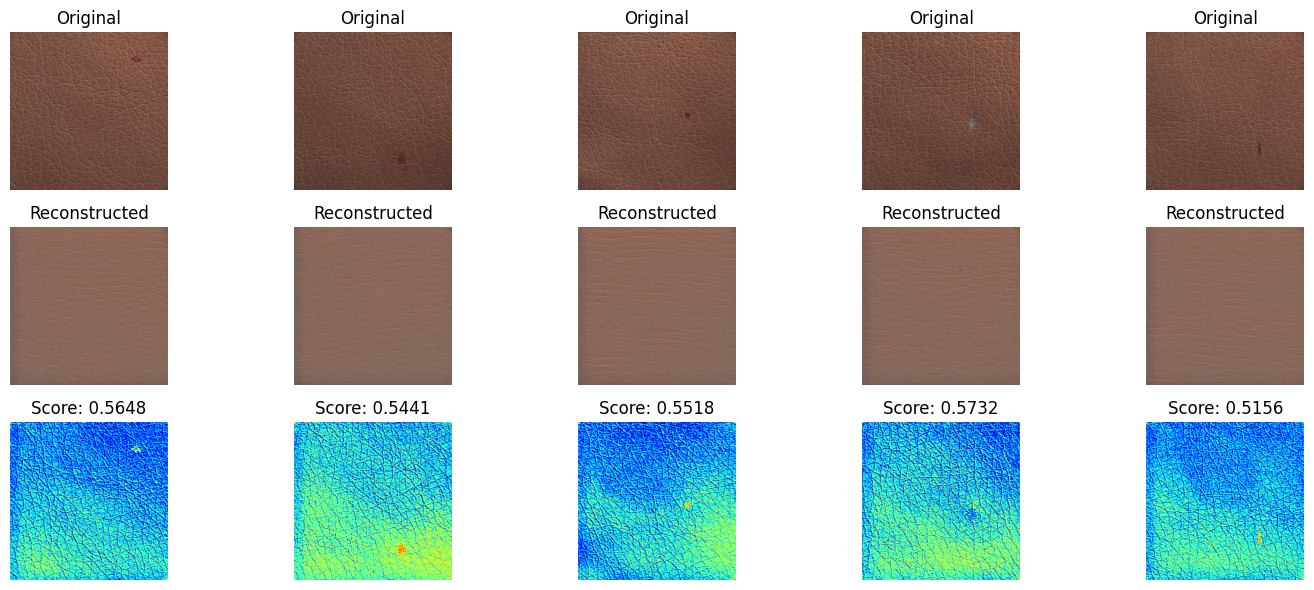

In [ ]:
def visualize_ssim_results(original, reconstructed, diff_maps, scores, n_samples=5):
    if len(original) == 0: return
    n_samples = min(n_samples, len(original))

    plt.figure(figsize=(15, 6))

    for i in range(n_samples):
        # Orijinal
        plt.subplot(3, n_samples, i + 1)
        plt.imshow(original[i])
        plt.title('Original')
        plt.axis('off')

        # Rekonstrüksiyon
        plt.subplot(3, n_samples, n_samples + i + 1)
        plt.imshow(reconstructed[i])
        plt.title('Reconstructed')
        plt.axis('off')

        # Hata Haritası
        plt.subplot(3, n_samples, 2*n_samples + i + 1)
        plt.imshow(diff_maps[i], cmap='jet', vmin=0, vmax=0.3) # Jet cmap highlights defects
        plt.title(f'Score: {scores[i]:.4f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if 'scores' in locals() and len(test_images) > 0:
    visualize_ssim_results(test_images, reconstructed, diff_maps, scores)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


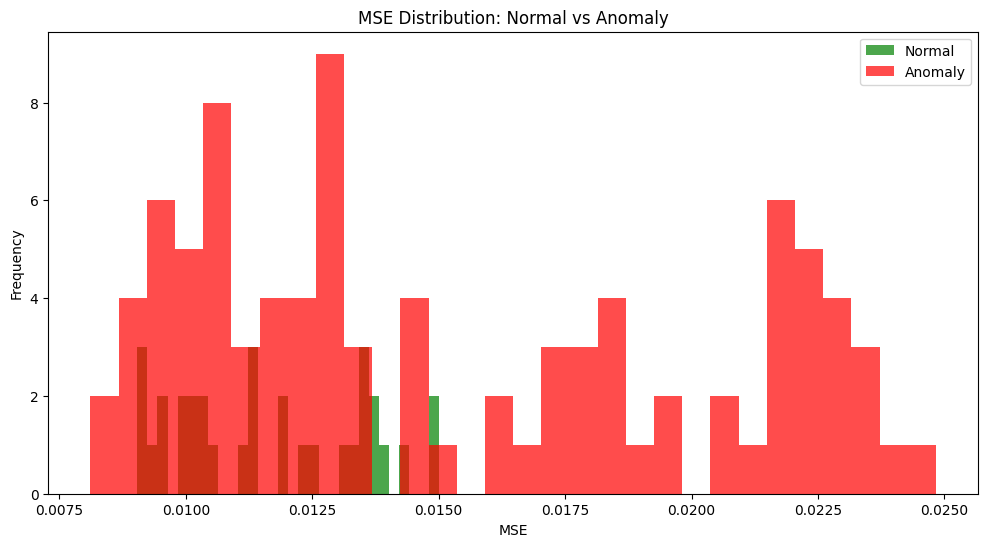

Normal MSE: 0.011679 ± 0.001842
Anomaly MSE: 0.015265 ± 0.005005
Separation ratio: 1.31x


In [ ]:
def evaluate_model(model, category=category):
    # Normal örnekler
    normal_path = f'/content/mvtec-ad/{category}/test/good'
    normal_images = load_images(normal_path)
    normal_recon = model.predict(normal_images)
    normal_mse = np.mean(np.square(normal_images - normal_recon), axis=(1,2,3))

    # Anomalili örnekler (tüm defekt tipleri)
    anomaly_mse = []
    defect_types = []

    test_path = Path(f'/content/mvtec-ad/{category}/test')
    for defect_dir in test_path.iterdir():
        if defect_dir.name != 'good' and defect_dir.is_dir():
            anomaly_images = load_images(str(defect_dir))
            anomaly_recon = model.predict(anomaly_images)
            mse = np.mean(np.square(anomaly_images - anomaly_recon), axis=(1,2,3))
            anomaly_mse.extend(mse)
            defect_types.extend([defect_dir.name] * len(mse))

    anomaly_mse = np.array(anomaly_mse)

    # Görselleştirme
    plt.figure(figsize=(12, 6))
    plt.hist(normal_mse, bins=30, alpha=0.7, label='Normal', color='green')
    plt.hist(anomaly_mse, bins=30, alpha=0.7, label='Anomaly', color='red')
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('MSE Distribution: Normal vs Anomaly')
    plt.show()

    # İstatistikler
    print(f"Normal MSE: {normal_mse.mean():.6f} ± {normal_mse.std():.6f}")
    print(f"Anomaly MSE: {anomaly_mse.mean():.6f} ± {anomaly_mse.std():.6f}")
    print(f"Separation ratio: {anomaly_mse.mean() / normal_mse.mean():.2f}x")

    return normal_mse, anomaly_mse

normal_scores, anomaly_scores = evaluate_model(model)